In [1]:
import sys
sys.path.append('/home/lo276838/Modèles/mri-dl-recon/src/mri_dlrecon')

In [2]:
from fastmri.data import transforms as T
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch.autograd import Variable

from models.utils.utils_torch import virtual_coil_reconstruction, load_and_transform, create_zero_filled_reconstruction
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.models.varnet import VarNet 


In [3]:
file_path = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/file_brain_AXT1POST_201_6002780.h5"

kspace_multicoil = load_and_transform(file_path)
images_multicoil = torch.fft.fftshift(torch.fft.ifft2(kspace_multicoil))

image = virtual_coil_reconstruction(images_multicoil)
kspace = torch.fft.fft2(image)


mask_type = "random"
center_fractions = [0.08, 0.04]
accelerations = [4, 8]
mask = create_mask_for_mask_type(mask_type, center_fractions, accelerations)

zero_filled_reconstruction , masked_data = create_zero_filled_reconstruction(mask,kspace)
zero_filled_reconstruction = torch.fft.fftshift(zero_filled_reconstruction)


In [4]:
shape_orig = zero_filled_reconstruction.shape
shape_nouveau = shape_orig + (2,)
tensor_nouveau = torch.zeros(shape_nouveau)
tensor_nouveau[..., 0] = zero_filled_reconstruction.real
tensor_nouveau[..., 1] = zero_filled_reconstruction.imag
print(tensor_nouveau.shape)

print(tensor_nouveau[2][0][5][8][0])
print(tensor_nouveau[2][0][5][8][1])
print(zero_filled_reconstruction[2][0][5][8])

torch.Size([16, 1, 640, 320, 2])
tensor(3.5054e-08)
tensor(2.1878e-08)
tensor(3.5054e-08+2.1878e-08j)


In [5]:
input = tensor_nouveau
target = image.abs().unsqueeze(1)
masked_data = masked_data.unsqueeze(-1)
masked_data = masked_data.unsqueeze(0)

print("mask : ",masked_data.shape)
print("target : ", target.shape)
print("input : ", input.shape)
print(input.dtype)

mask :  torch.Size([1, 1, 640, 1, 1])
target :  torch.Size([16, 1, 640, 320])
input :  torch.Size([16, 1, 640, 320, 2])
torch.float32


In [6]:
new_size = (input.shape[0],) + masked_data.size()[1:]
masked_data = masked_data.expand(new_size)

print("mask : ",masked_data.shape)
print("target : ", target.shape)
print("input : ", input.shape)


mask :  torch.Size([16, 1, 640, 1, 1])
target :  torch.Size([16, 1, 640, 320])
input :  torch.Size([16, 1, 640, 320, 2])


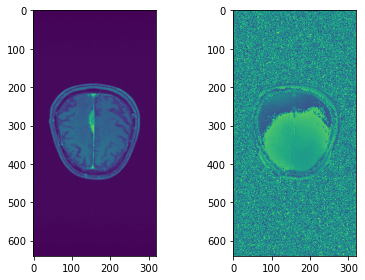

In [7]:
plt.subplot(1,2,1)
plt.imshow(np.abs(image[0]))

plt.subplot(1,2,2)
plt.imshow(np.angle(image[0]))

plt.tight_layout()
plt.show()

In [8]:
# chans = 32
# num_pool_layers = 4
# lr = 0.0001

# model = VarNet(chans=chans, pools=num_pool_layers)
# criterion = torch.nn.L1Loss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# loss_list = []
# num_epochs = 1
# for epoch in range(num_epochs):
#     input = Variable(input)
#     target = Variable(target)

#     optimizer.zero_grad()
#     outputs = model(input, masked_data)
#     loss = criterion(outputs, target)
#     loss_list.append(loss.item())

#     loss.backward()
#     optimizer.step()

#     # print(f'Epoch [{epoch+1}/{num_epochs}]')

# # Sauvegarder le modèle
# torch.save(model.state_dict(), 'fastmri_unet_model.pth')


In [14]:
from fastmri.data import transforms
from fastmri.data.subsample import RandomMaskFunc

chans = 32
center_fractions = [0.08]
accelerations = [4]
mask_center = True

mask_func = RandomMaskFunc(center_fractions, accelerations)
x = tensor_nouveau
outputs, masks = [], []
for i in range(x.shape[0]):
    output, mask, _ = transforms.apply_mask(x[i : i + 1], mask_func, seed=123)
    outputs.append(output)
    masks.append(mask)

output = torch.cat(outputs)
mask = torch.cat(masks)

varnet = VarNet(
    num_cascades=2,
    sens_chans=4,
    sens_pools=2,
    chans=chans,
    pools=2,
    mask_center=mask_center,
)

y = varnet(output, mask.byte())


# mask_func = create_mask_for_mask_type("random", center_fractions, accelerations)

# shape_nouveau = x.shape + (2,)
# tensor_nouveau = torch.zeros(shape_nouveau)
# print(tensor_nouveau.shape)
# print(x[2][0][21][12])
# tensor_nouveau[..., 0] = x.real
# tensor_nouveau[..., 1] = x.imag
# print(tensor_nouveau.shape)


# outputs, masks = [], []
# for i in range(tensor_nouveau.shape[0]):
#     output, mask, _ = transforms.apply_mask(tensor_nouveau[i : i + 1], mask_func, seed=123)
#     outputs.append(output)
#     masks.append(mask)

# output = torch.cat(outputs)
# mask = torch.cat(masks)

# varnet = VarNet(
#     num_cascades=2,
#     sens_chans=4,
#     sens_pools=2,
#     chans=chans,
#     pools=4,
#     mask_center=mask_center,
# )
# print("out : ", output.shape)
# print("mask : ", mask.shape)

# y = varnet(output, mask.byte())
# print(y.shape)